## Milne-Eddington Inversions of an IBIS dataset

We are now going to work with filtergraph data. The main idea is the same, but now, modeling the transmission profile of the filter is really important. As we said, the spectral PSF is the part of our model, and even thought we are not fitting for it, we do have to account for it. 

This is some IBIS data... FILL IN WITH MORE STUFF

In [2]:
# Standard suite of imports ;) 

import numpy as np
import matplotlib.pyplot as plt
import MilneEddington as ME
from astropy.io import fits
from scipy.io import readsav

In [13]:
# Look at me, I can even read radsav from python
data = readsav("/home/milic/scratch/ibis.6302.stokes.scan.14Jun2005.ser1447.seq0.sav")
data.keys()

dict_keys(['ibis_6302_stokes', 'waves_6302_even', 'waves_6302_orig'])

In [21]:
stokes = np.squeeze(data["ibis_6302_stokes"])
stokes.shape

(4, 20, 876, 424)

In [22]:
stokes = stokes.transpose(2,3,0,1)
stokes.shape

(876, 424, 4, 20)

Look at that, 120 x 350 image, with 4 Stokes parameters, but only 20 wavelengths.

To see the spectra properly, we have to load wavelengths too:

In [23]:
ll = data["waves_6302_even"]
print (ll)

[6302.22510234 6302.25280234 6302.28050234 6302.30820234 6302.33590234
 6302.36360235 6302.39130234 6302.41900233 6302.44670234 6302.47440235
 6302.50210235 6302.52980233 6302.55750234 6302.58520234 6302.61290232
 6302.64060233 6302.66830234 6302.69600234 6302.72370235 6302.75140236]


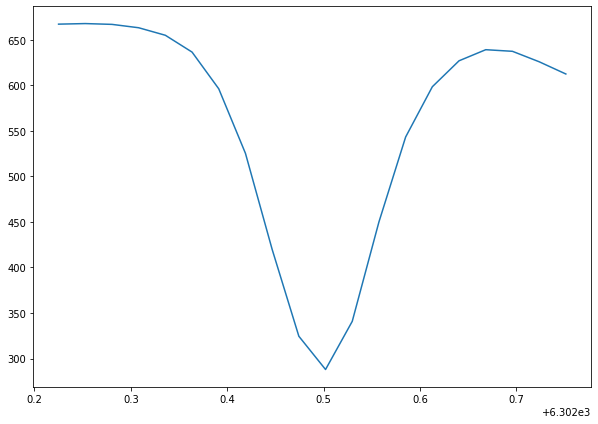

In [24]:
# Let's take a look at the mean spectrum:
mean = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(ll,mean[0])

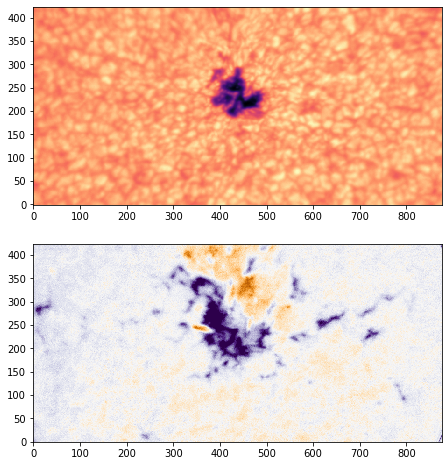

In [29]:
# let's normalize and look at some images:
# Can anyone guess why am I doing this? :)
stokes = np.copy(stokes)
stokes /= np.mean(stokes[:,:,0,0])

# Let's look at some images:
plt.figure(figsize=[10,8])
plt.subplot(211)
plt.imshow(stokes[:,:,0,0].T,cmap='magma',origin='lower')
plt.subplot(212)
plt.imshow(stokes[:,:,3,8].T,vmin=-0.05,vmax=0.05,cmap='PuOr',origin='lower')

Now, let's make that noise array, to appropriately weight all the wavelengths:

In [33]:
noise= np.zeros((4,ll.size), dtype='float64')
noise[:] = 1E-3

In [40]:
%%time
i = 0
j = 0
nx,ny = stokes.shape[:2]
to_fit = stokes[i:i+nx,j:j+nx,:,:]
# Let's fit:

regions = [[ll,None]]
lines = [6302]
me = ME.MilneEddington(regions, lines, nthreads=8)

# guess model
guess_model = np.float64([1500, 2.2, 1.0, -0.5, 0.035, 50., 0.1, 0.24, 0.7])
guess_models = me.repeat_model(guess_model, nx, ny)

# Let's jam some inversions, again mu = 0.93 is something that we should know from the fits file
model_out, syn, chi2 = me.invert(guess_models, to_fit, noise, nRandom=5, nIter=25, chi2_thres=1.0, mu=1.0)

pyMilne::dealloc: cleaning-up...
CPU times: user 13min 17s, sys: 1.4 s, total: 13min 18s
Wall time: 2min 6s


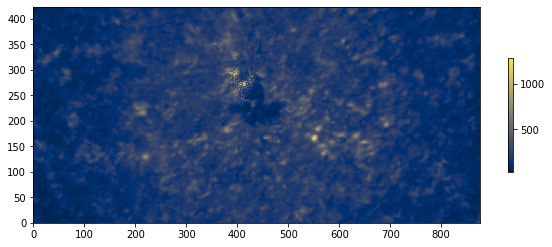

In [49]:
# Let's plot our chisquared:
plt.figure(figsize=[10,7])
plt.imshow(chi2.T,origin='lower',cmap='cividis')
plt.colorbar(shrink=0.3)

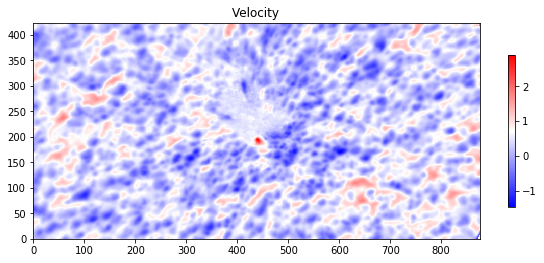

In [47]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3].T,origin='lower',cmap='bwr')
plt.title("Velocity")
plt.colorbar(shrink=0.4)

For sunspots, and in general for velocities, there are numerous "corrections" you can make to make this be meaningful. We can discuss these separately (what is zero velocity is actually a touchy question :))

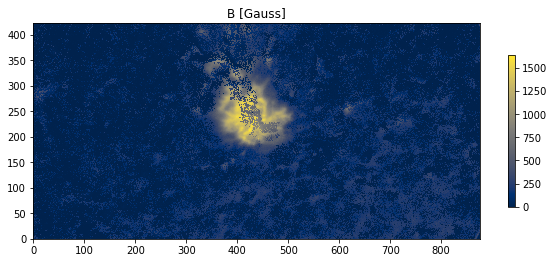

In [46]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0].T,origin='lower',cmap='cividis')
plt.title("B [Gauss]")
plt.colorbar(shrink=0.4)

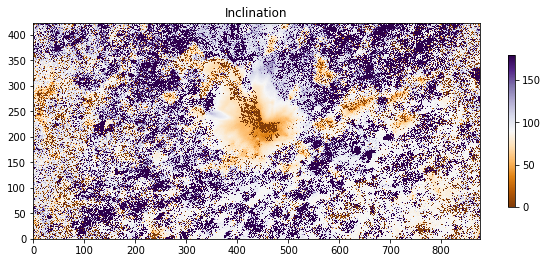

In [45]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,1].T*180./np.pi,origin='lower',cmap='PuOr')
plt.title("Inclination")
plt.colorbar(shrink=0.4)